In [1]:
%pylab inline
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


## Compute linear fits to yields

In [76]:
from Chempy.yields import SN2_feedback,SN1a_feedback,AGB_feedback
basic_sn2 = SN2_feedback()
basic_sn2.TNG_net()
basic_agb = AGB_feedback()
basic_agb.TNG_net()
basic_sn1a = SN1a_feedback()
basic_sn1a.TNG()

In [204]:
## Fitting parameters
sn2_max = 100.
sn2_min = 8.
agb_max = 8.
agb_min = 1.
elements = a.elements_to_trace

In [242]:
from sklearn import linear_model

# Fit SN2 data:
sn2_met = basic_sn2.metallicities.copy()
sn2_mass = basic_sn2.masses.copy()
# Filter out yields outside required range
mass_indices = np.argwhere((sn2_mass<=sn2_max)&(sn2_mass>=sn2_min)).T[0]
sn2_mass = sn2_mass[mass_indices]

sn2_coeffs = []

for elem in list(elements)+['mass_in_remnants']:
    clf = linear_model.LinearRegression()
    
    all_yields,all_m,all_Z = [[] for _ in range(3)]
    for met in sn2_met:
        all_m += list(sn2_mass)
        all_yields += list(basic_sn2.table[met][elem][mass_indices])
        all_Z += [np.log10(np.max([met,1e-5])) for _ in range(len(mass_indices))] # avoid zero errors
    all_yields = np.asarray(all_yields).reshape(-1,1)
    all_m = np.asarray(all_m)
    all_Z = np.asarray(all_Z)
    
    # Now perform least squares regression
    X_matrix = np.vstack([all_m,all_Z]).T
    clf.fit(X_matrix,all_yields)
    
    # Compute [intercept,mass-slope,log-Z-slope]
    coeffs = np.hstack([[clf.intercept_],clf.coef_])[0]
    sn2_coeffs.append(coeffs)

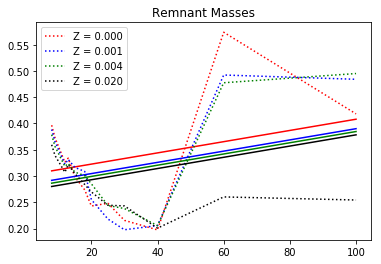

In [245]:
cols=['r','b','g','k','o','y']
for i in range(len(sn2_met)):
    plt.plot(sn2_mass,all_yields[i*len(sn2_mass):(i+1)*len(sn2_mass)],label='Z = %.3f'%(sn2_met[i]),c=cols[i],ls=':')
    plt.plot(sn2_mass,sn2_coeffs[-1][0]+sn2_coeffs[-1][1]*sn2_mass+sn2_coeffs[-1][2]*np.log10(np.max([sn2_met[i],1e-5])),c=cols[i])
plt.legend()
plt.title('Remnant Masses');

In [246]:
from sklearn import linear_model

# Fit AGB data:
agb_met = basic_agb.metallicities.copy()
agb_mass = basic_agb.masses.copy()
# Filter out yields outside required range
mass_indices = np.argwhere((agb_mass<=agb_max)&(agb_mass>=agb_min)).T[0]
agb_mass = agb_mass[mass_indices]

agb_coeffs = []

for elem in list(elements)+['mass_in_remnants']:
    clf = linear_model.LinearRegression()
    
    all_yields,all_m,all_Z = [[] for _ in range(3)]
    for met in agb_met:
        all_m += list(agb_mass)
        all_yields += list(basic_agb.table[met][elem][mass_indices])
        all_Z += [np.log10(np.max([met,1e-5])) for _ in range(len(mass_indices))] # avoid zero errors
    all_yields = np.asarray(all_yields).reshape(-1,1)
    all_m = np.asarray(all_m)
    all_Z = np.asarray(all_Z)
    
    # Now perform least squares regression
    X_matrix = np.vstack([all_m,all_Z]).T
    clf.fit(X_matrix,all_yields)
    
    # Compute [intercept,mass-slope,log-Z-slope]
    coeffs = np.hstack([[clf.intercept_],clf.coef_])[0]
    agb_coeffs.append(coeffs)

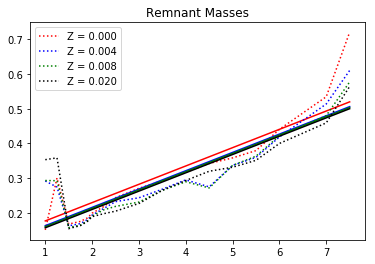

In [249]:
cols=['r','b','g','k','o','y']
for i in range(len(agb_met)):
    plt.plot(agb_mass,all_yields[i*len(agb_mass):(i+1)*len(agb_mass)],label='Z = %.3f'%(agb_met[i]),c=cols[i],ls=':')
    plt.plot(agb_mass,agb_coeffs[-1][0]+agb_coeffs[-1][1]*agb_mass+agb_coeffs[-1][2]*np.log10(np.max([agb_met[i],1e-5])),c=cols[i])
plt.legend()
plt.title('Remnant Masses');

In [270]:
from sklearn import linear_model

# Fit SN1a data: (only one metallicity and mass here)

sn1a_coeffs = []
sn1a_met = basic_sn1a.metallicities[0]

for elem in list(elements)+['mass_in_remnants']:
    clf = linear_model.LinearRegression()
    
    # Compute [intercept]
    sn1a_coeffs.append(basic_sn1a.table[sn1a_met][elem][0])

## Save coefficients to file

Each process has a list of coefficients for each element, with the last coefficient being for the mass_in_remnants/
For AGB and SN2 yields, coefficients have the form (intercept, mass_coefficient, logZ_coefficient) with simply an intercept for the SN1a yields.

In [252]:
np.savez('TNG_Linear_Yield_Fits.npz',sn2=sn2_coeffs,agb=agb_coeffs,sn1a=sn1a_coeffs)

## Compute proto-solar abundances

##### Are these [X/Fe] or [Fe/H] abundances??

In [265]:
dat=np.load('Chempy/input/stars/Proto-sun_all.npy') # load data

obs_dat = []
obs_err = []
obs_elements = []
for el in elements:
    if el=='H':
        continue
    obs_dat.append(dat[el][0])
    obs_err.append(dat[el][1])
    obs_elements.append(el)
assert len(obs_dat)==len(elements)-1 # ignoring H
    
age = dat['age'][0]
age_err = dat['age'][1]

# Save to file
np.savez('Proto_Solar_Observations.npz',abundances=obs_dat,errors=obs_err,elements=obs_elements,
        age = age, age_error = age_err)

In [269]:
for i in range(8):
    print("%s %.2f +- %.2f"%(obs_elements[i],obs_dat[i],obs_err[i]))

C 0.00 +- 0.06
Fe 0.04 +- 0.05
He 0.01 +- 0.02
Mg 0.00 +- 0.05
N 0.00 +- 0.06
Ne 0.00 +- 0.11
O 0.00 +- 0.06
Si 0.00 +- 0.04
